## **Homework - Seesion 4**

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## **Data**:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## **Preparation** 

> ### We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [93]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv')
df.columns = df.columns.str.lower()

> ### Some of the features are encoded as numbers. Use the following code to de-code them:

In [94]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

> ### Prepare the numerical variables:

In [95]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

> ### Remove clients with unknown default status

In [96]:
df = df[df.status != 'unk'].reset_index(drop=True)

> ### Create the target variable

In [97]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## **What are the categorical variables? What are the numerical?**

In [98]:
df.shape

(4454, 14)

In [99]:
var_cat = df.select_dtypes(include='O').columns
print(len(var_cat), '\n', var_cat)

4 
 Index(['home', 'marital', 'records', 'job'], dtype='object')


In [100]:
var_num = df.select_dtypes(include=['int', 'float']).columns
print(len(var_num),'\n', var_num)

10 
 Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price', 'default'],
      dtype='object')


In [101]:
# target = df.default
# features = df[df.columns.drop('default')]

## **Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.** 
## **Use `train_test_split` function for that with `random_state=1`**


In [102]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_valid = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [103]:
print(round(len(df_train)/len(df),2))
print(round(len(df_valid)/len(df),2))
print(round(len(df_test)/len(df),2))

0.6
0.2
0.2


## **Import Libs**

In [104]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import recall_score, precision_score

## **Question 1**

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [105]:
for col in var_num:
    auc_score = roc_auc_score(df_train.default, df_train[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(df_train.default, -df_train[col])
    print(f"{col: <10}: {auc_score: .2f}")  

seniority :  0.71
time      :  0.56
age       :  0.57
expenses  :  0.50
income    :  0.68
assets    :  0.65
debt      :  0.50
amount    :  0.59
price     :  0.50
default   :  1.00


> ### **Which numerical variable (among the following 4) has the highest AUC?**

- **seniority**
- time
- income
- debt

## **Training the model**

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [106]:
feat_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

# OHE
dv = DictVectorizer()
train_dict = df_train[feat_cols].to_dict(orient = 'records')
val_dict = df_valid[feat_cols].to_dict(orient = 'records')

# X_train | y_train
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
y_train = df_train['default'].values
y_valid = df_valid['default'].values

# Fit
clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X_val)[:, 1]

## **Question 2**

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- **0.812**

In [107]:
# AUC
auc_score = roc_auc_score(y_valid, predictions)
print(f"AUC: {auc_score: .3f}")

AUC:  0.812


## **Question 3**

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

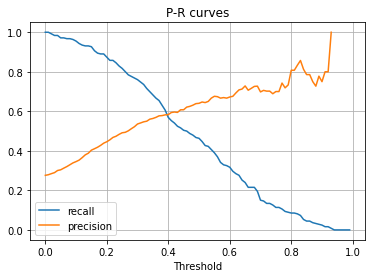

In [112]:
thresholds = np.arange(0, 1.0, 0.01)
scores = []

for i in thresholds:
    actual_positive = (y_valid == 1)
    actual_negative = (y_valid == 0)

    predict_positive = (predictions >= i)
    predict_negative = (predictions < i)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((i, tp, fp, fn, tn))

# df_scores 
cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=cols)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)  
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn) 
      
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

# plot
# plt.plot(df_scores[['precision', 'recall']])
plt.plot(df_scores.threshold, df_scores['tpr'], label='recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.xlabel('Threshold')
plt.title('P-R curves')
plt.legend()
# plt.show()
plt.grid()

At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6
* 0.8

## **Question 4**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [68]:
df_scores['f1'] = 2 * (df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)
df_scores[df_scores['f1'] == max(df_scores['f1'])]

,threshold,tp,fp,fn,tn,precision,recall,tpr,fpr,f1
30,0.3,187,162,59,483,0.535817,0.760163,0.760163,0.251163,0.628571


At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

## **Question 5**


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [73]:
from sklearn.model_selection import KFold

scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        
        df_train = df_full_train.iloc[train_idx]
        df_valid = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_valid = df_valid.default.values

        # OHE
        train_dict = df_train[feat_cols].to_dict(orient='records')
        val_dict = df_valid[feat_cols].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)

        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        # Train model
        clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        clf.fit(X_train, y_train)

        # AUC
        y_pred = clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)

        scores.append(auc)

        print(f"Fold {fold} - ROC AUC {auc}")

print(f"STD - Scores {np.std(scores): .3f}")

Fold 0 - ROC AUC 0.8256212256212256
Fold 1 - ROC AUC 0.8254077031563474
Fold 2 - ROC AUC 0.789298525308888
Fold 3 - ROC AUC 0.8153421373265731
Fold 4 - ROC AUC 0.8054696294614563
STD - Scores  0.014


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [86]:
scores = []
c_values = [0.01, 0.1, 1, 10]
kfold = KFold(n_splits=5, shuffle=True, random_state = 1)

for val in c_values:
    kfold_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
            
            df_train = df_full_train.iloc[train_idx, :]
            df_val = df_full_train.iloc[val_idx, :]

            y_train = df_train.default.values
            y_val = df_val.default.values

            train_dict = df_train[feat_cols].to_dict(orient='records')
            val_dict = df_val[feat_cols].to_dict(orient='records')
        
            dv = DictVectorizer(sparse=False)
        
            X_train = dv.fit_transform(train_dict)
            X_val = dv.transform(val_dict)

            clf = LogisticRegression(solver='liblinear', C=val, max_iter=1000)
            clf.fit(X_train, y_train)

            y_pred = clf.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            
            kfold_scores.append(auc)
    
    # mean & std scores
    mean_auc = np.mean(kfold_scores)
    std = np.std(kfold_scores)
    
    # kfold_scores & scores
    kfold_scores.extend([mean_auc, std])
    scores.append(kfold_scores)
    
    print(f"C={val:<4}  |  MEAN roc_auc_score: {mean_auc:.3f}   |   STD: {std:.3f}")

C=0.01  |  MEAN roc_auc_score: 0.809   |   STD: 0.013
C=0.1   |  MEAN roc_auc_score: 0.813   |   STD: 0.014
C=1     |  MEAN roc_auc_score: 0.812   |   STD: 0.014
C=10    |  MEAN roc_auc_score: 0.814   |   STD: 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.